<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-Image-Classification-Projects/blob/main/PyTorch-CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet18 Implementation on CIFAR10 Dataset

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import torchmetrics
from torchmetrics import Accuracy, Recall, Precision

import matplotlib.pyplot as plt

import numpy as np

In [3]:
# Define Transformations

# Train set transformations (Augmentation included)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2023, 0.1994, 0.2010))
])

# Test set transformations (No Augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Load Dataset

# Train set
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test set
test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


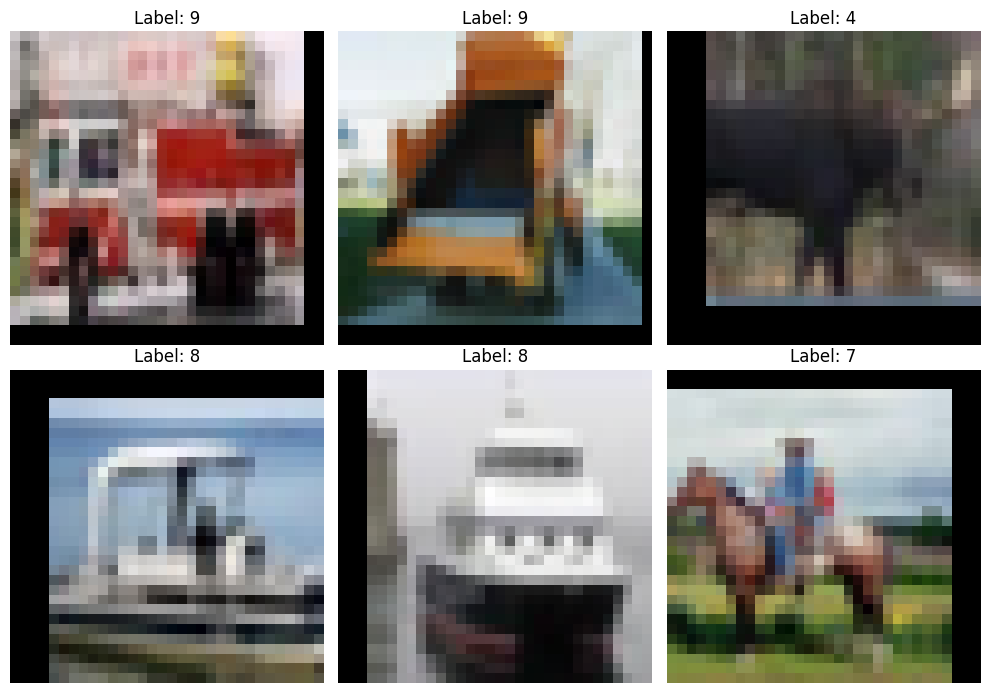

In [5]:
# Display image samples from train set
data_iter = iter(trainloader)
images, labels = next(data_iter)

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.flatten()

for i in range(6):
    img = images[i].numpy().transpose(1, 2, 0)
    img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4471])
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Define CNN Architecture (ResNet18)
class ResNetBlock(nn.Module):
  def __init__(self, channel_in, channel_out, stride, downsample):
    super(ResNetBlock, self).__init__()

    self.conv1 = nn.Conv2d(channel_in, channel_out, 3, stride, 1)
    self.bn1 = nn.BatchNorm2d(channel_out)
    self.conv2 = nn.Conv2d(channel_out, channel_out, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(channel_out)

    self.dropout = nn.Dropout(0.3)

    self.downsample = downsample

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    i = x

    y = self.conv1(x)
    y = self.bn1(y)
    y = self.relu(y)

    y = self.conv2(y)
    y = self.bn2(y)

    if self.downsample is not None:
      i = self.downsample(x)

    y += i
    y = self.relu(y)
    y = self.dropout(y)

    return y

class ResNet(nn.Module):
  def __init__(self, img_channel, classes_amt):
    super(ResNet, self).__init__()

    self.conv1 = nn.Conv2d(img_channel, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layers1 = self.make_layer(64, 64, stride=1)
    self.layers2 = self.make_layer(64, 128, stride=2)
    self.layers3 = self.make_layer(128, 256, stride=2)
    self.layers4 = self.make_layer(256, 512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, classes_amt)

  def make_layer(self, in_channel, out_channel, stride):
    downsample = None
    if stride != 1:
      downsample = nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channel)
      )

    return ResNetBlock(in_channel, out_channel, stride, downsample)

  def forward(self, x):
    y = self.conv1(x)
    y = self.bn1(y)
    y = self.relu(y)
    y = self.maxpool(y)

    x = self.layers1(y)
    x = self.layers2(x)
    x = self.layers3(x)
    x = self.layers4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

In [7]:
# Specify GPU for traning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# Define for training
train_accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
train_precision = Precision(task="multiclass", average='macro', num_classes=10).to(device)
train_recall = Recall(task="multiclass", average='macro', num_classes=10).to(device)

# Define for testing
test_accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
test_precision = Precision(task="multiclass", average='macro', num_classes=10).to(device)
test_recall = Recall(task="multiclass", average='macro', num_classes=10).to(device)

In [8]:
# Initialize Model
model = ResNet(3, 10).to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters())

In [22]:
def train(model, train_loader, test_loader, optimizer, criterion, epochs):
    model.train()
    train_loss, train_acc, test_loss, test_acc = [], [], [], []

    for epoch in range(epochs):
        total_loss = 0

        # Reset torchmetrics for this epoch
        train_accuracy.reset()
        train_precision.reset()
        train_recall.reset()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            train_accuracy.update(preds, labels)
            train_precision.update(preds, labels)
            train_recall.update(preds, labels)

        # Compute metrics and move to CPU for logging
        avg_loss = total_loss / len(train_loader)
        acc = train_accuracy.compute().cpu().item()
        prec = train_precision.compute().cpu().item()
        rec = train_recall.compute().cpu().item()

        train_loss.append(avg_loss)
        train_acc.append(acc)

        # Test after each epoch
        test_epoch_loss, test_epoch_acc = test(model, test_loader, criterion)
        test_loss.append(test_epoch_loss)
        test_acc.append(test_epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

    return train_loss, train_acc, test_loss, test_acc

In [23]:
# Function for testing
def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0

    # Reset metrics
    test_accuracy.reset()
    test_precision.reset()
    test_recall.reset()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            test_accuracy.update(preds, labels)
            test_precision.update(preds, labels)
            test_recall.update(preds, labels)

    avg_loss = total_loss / len(test_loader)
    acc = test_accuracy.compute().item()
    prec = test_precision.compute().item()
    rec = test_recall.compute().item()

    print(f"Test | Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    return avg_loss, acc

Test | Loss: 0.5770, Acc: 0.8075, Precision: 0.8121, Recall: 0.8075
Epoch 1/10 | Train Loss: 0.9401, Acc: 0.7402, Precision: 0.7400, Recall: 0.7402
Test | Loss: 0.6018, Acc: 0.8039, Precision: 0.8102, Recall: 0.8039
Epoch 2/10 | Train Loss: 0.5162, Acc: 0.8196, Precision: 0.8193, Recall: 0.8196
Test | Loss: 0.7457, Acc: 0.7731, Precision: 0.8033, Recall: 0.7731
Epoch 3/10 | Train Loss: 0.4905, Acc: 0.8321, Precision: 0.8321, Recall: 0.8321
Test | Loss: 0.5777, Acc: 0.8056, Precision: 0.8149, Recall: 0.8056
Epoch 4/10 | Train Loss: 0.4763, Acc: 0.8353, Precision: 0.8352, Recall: 0.8353
Test | Loss: 0.5679, Acc: 0.8195, Precision: 0.8245, Recall: 0.8195
Epoch 5/10 | Train Loss: 0.4685, Acc: 0.8373, Precision: 0.8371, Recall: 0.8373
Test | Loss: 0.6133, Acc: 0.8015, Precision: 0.8122, Recall: 0.8015
Epoch 6/10 | Train Loss: 0.4628, Acc: 0.8391, Precision: 0.8391, Recall: 0.8391
Test | Loss: 0.5946, Acc: 0.8124, Precision: 0.8216, Recall: 0.8124
Epoch 7/10 | Train Loss: 0.4570, Acc: 0.8434

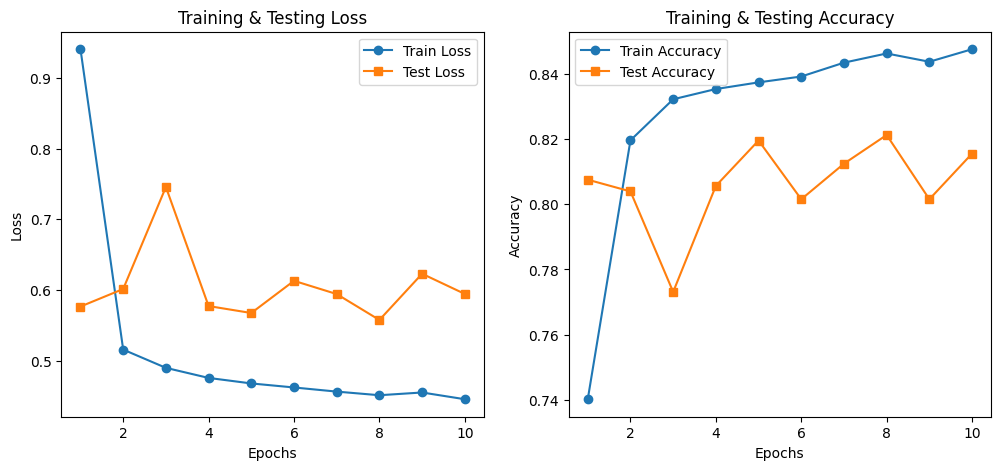

In [24]:
# Train and Test the Model
epochs = 10
train_loss, train_acc, test_loss, test_acc = train(model, trainloader, testloader, optimizer, criterion, epochs)

# Plot Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", marker='o')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Testing Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy", marker='o')
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Testing Accuracy")
plt.legend()

plt.show()

Classification Report:
              precision    recall  f1-score   support

    airplane       0.85      0.82      0.83      1000
  automobile       0.87      0.93      0.90      1000
        bird       0.85      0.72      0.78      1000
         cat       0.59      0.72      0.65      1000
        deer       0.84      0.77      0.81      1000
         dog       0.77      0.66      0.71      1000
        frog       0.87      0.87      0.87      1000
       horse       0.83      0.87      0.85      1000
        ship       0.83      0.94      0.88      1000
       truck       0.91      0.84      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



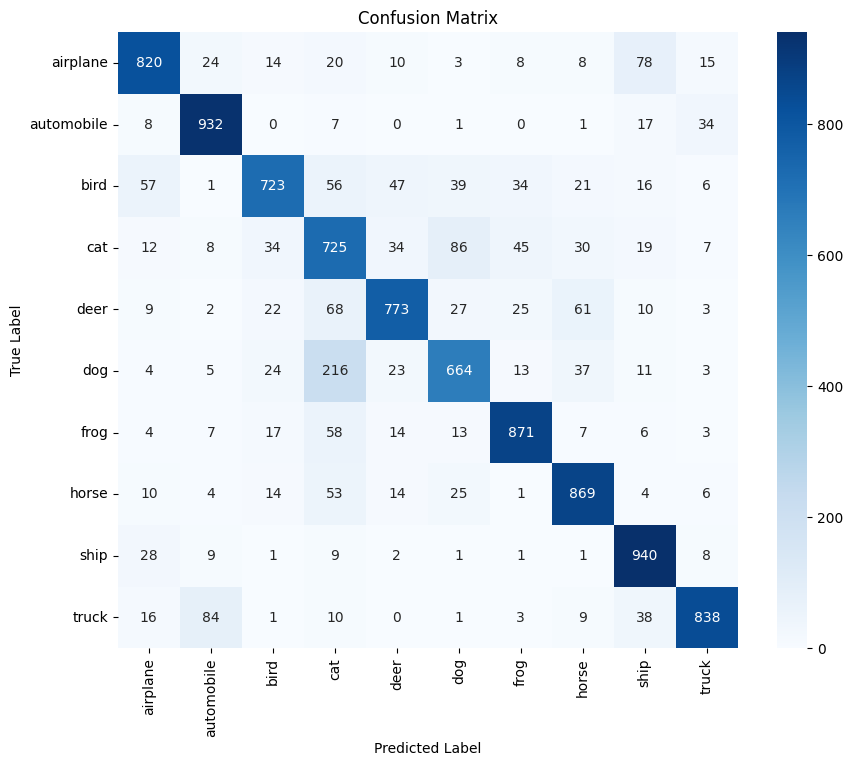

In [25]:
from torchmetrics import ConfusionMatrix
from sklearn.metrics import classification_report
import seaborn as sns

# Function for evaluation
def evaluate(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Get predictions and true labels
true_labels, predictions = evaluate(model, testloader)

# Generate Classification Report
classes = test_dataset.classes
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=classes))

# Generate Confusion Matrix
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=10)
conf_matrix_tensor = conf_matrix(torch.tensor(predictions), torch.tensor(true_labels))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tensor.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()